![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [1]:
import pandas as pd #Importing Pandas 
import numpy as np #Importing Numpy
import matplotlib.pyplot as plt #Importing Pyplot for plots
import seaborn as sns #Importing Seaborn for plots
from sklearn.preprocessing import LabelBinarizer #Binarizing the label for softmax function
from tensorflow import keras #Import Keras for building Neural Network
import datetime #Used for Logging
from sklearn.metrics import multilabel_confusion_matrix # Confusion Metrics
import matplotlib.image as mpimg #Used to display the images 
from PIL import Image #Used to display the images 
import tensorflow #Used for models 
import cv2 #Used to display the images 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [3]:
from google.colab import drive #For importing the data from google drive
drive.mount('/content/drive/') #Mounting the drive
Image_Data = np.load('/content/drive/My Drive/Colab Notebooks/Face_Mask_Prediction/images.npy' ,encoding='bytes',allow_pickle=True) #Reading the file 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual data in data[10][1] 
 [{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


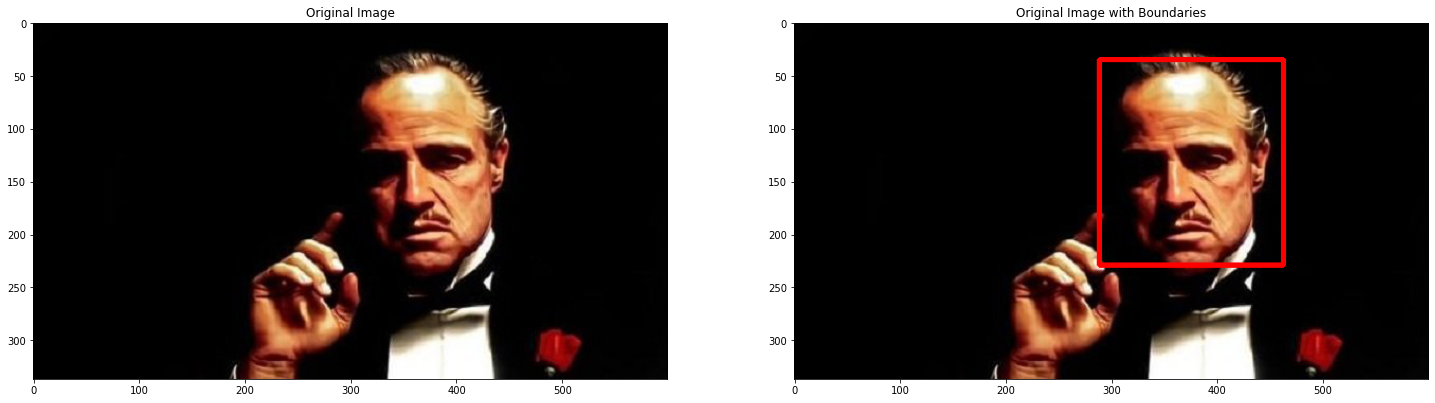

In [102]:
#Displaying the original Data 
#First column in the array has the Image Matrix
#Second column in the array has the Image Mask details
print('Actual data in data[10][1] \n {}'.format(Image_Data[10][1]))
height=[sub['imageHeight'] for sub in Image_Data[10][1]] #Getting the image height for the mask
width=[sub['imageWidth'] for sub in Image_Data[10][1]] #Getting the image width for the mask
x0,x1=[p['x'] for p in [sub['points'] for sub in Image_Data[10][1]][0]] #Getting the x coordinates of bounding box
y0,y1=[p['y'] for p in [sub['points'] for sub in Image_Data[10][1]][0]] #Getting the y coordinates of bounding box
x0=x0*width[0] #Multiplying the x coordinates with width of the bounding box to denormalize
x1=x1*width[0] #Multiplying the x coordinates with width of the bounding box to denormalize
y0=y0*height[0] #Multiplying the y coordinates with height of the bounding box to denormalize
y1=y1*height[0] #Multiplying the y coordinates with height of the bounding box to denormalize
x0=int(x0)#Converting Float to Int 
x1=int(x1)#Converting Float to Int
y0=int(y0)#Converting Float to Int
y1=int(y1)#Converting Float to Int
ax = [] #Creating the array of plots for subplot
fig = plt.figure(figsize=(25, 25)) #Defining the size of the image
img = Image.fromarray(Image_Data[10][0]) #Reading the image from the array
img.save('testrgb.png')#Saving the array which has been read to Image
i=mpimg.imread('testrgb.png')# Reading the Image
ax.append(fig.add_subplot(1, 2, 1))#Creating the first subplot the original Image
plt.imshow(i)#Display the image
ax[0].set_title('Original Image')#Setting the title of the image
img = cv2.rectangle(i,(x0,y0),(x1,y1),(255,0,0),3)# Drawing the rectangle with the given x&y coordinates
ax.append(fig.add_subplot(1, 2, 2))#Creating the second subplot with the boundary box
ax[1].set_title('Original Image with Boundaries')#Setting the title of the image
plt.imshow(img)#Display the image
plt.show()#Display the image

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [5]:
#Setting the Image Width and Height to 224
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [6]:
from tensorflow.keras.applications.mobilenet import preprocess_input#Calling the Preprocess_input function 

masks = np.zeros((int(Image_Data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))#Creating  the array for Mask details
X = np.zeros((int(Image_Data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))#Creating  the array for Image details
for index in range(Image_Data.shape[0]):#For each image matrix below transformation will be done
    img = Image_Data[index][0]#Read the image
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)#Resize the image to 224*224
    try:#exception Handling
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))#Passing the Image array to the Preprocess_input to get in format required for Mobilenet
    for i in Image_Data[index][1]:# For each Mask details
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)#Getting the x& y coordinates
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1#Appending the details for Mask array

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

In [7]:
X_train = X[:309]#Getting the 400 Images for train 
y_train=masks[:309]#Getting the 400 Images for train 
X_test = X[-9:]#Getting the 9 Images for test 
y_test=masks[-9:]#Getting the 9 Images for test
print('Shape of X_train: {}'.format(X_train.shape))
print('Shape of y_train: {}'.format(y_train.shape))
print('\nShape of X_test: {}'.format(X_test.shape))
print('Shape of y_test: {}'.format(y_test.shape))

Shape of X_train: (309, 224, 224, 3)
Shape of y_train: (309, 224, 224)

Shape of X_test: (9, 224, 224, 3)
Shape of y_test: (9, 224, 224)


### Print a sample training & test image, image array and its mask (2 marks)

In [8]:
#Displaying 23rd row of train data
print('Train Image Sample Array: \n{}'.format(X_train[24]))
print('\nTrain Image Sample Mask: \n',y_train[24])

Train Image Sample Array: 
[[[ 0.87450981  0.80392158  0.7647059 ]
  [ 0.87450981  0.80392158  0.7647059 ]
  [ 0.87450981  0.80392158  0.7647059 ]
  ...
  [-0.58431375 -0.5529412  -0.54509807]
  [-0.23137254 -0.3098039  -0.25490195]
  [ 0.15294123  0.082353    0.082353  ]]

 [[ 0.87450981  0.80392158  0.7647059 ]
  [ 0.87450981  0.80392158  0.7647059 ]
  [ 0.87450981  0.80392158  0.7647059 ]
  ...
  [ 0.04313731 -0.03529412 -0.14509803]
  [ 0.17647064  0.11372554 -0.05098039]
  [-0.19999999 -0.23137254 -0.27843136]]

 [[ 0.87450981  0.80392158  0.7647059 ]
  [ 0.87450981  0.80392158  0.7647059 ]
  [ 0.87450981  0.80392158  0.7647059 ]
  ...
  [-0.41960782 -0.52941179 -0.67058825]
  [-0.57647061 -0.62352943 -0.83529413]
  [-0.89019608 -0.90588236 -0.99215686]]

 ...

 [[ 0.74117649  0.56862748  0.48235297]
  [ 0.72549021  0.54509807  0.48235297]
  [ 0.73333335  0.51372552  0.48235297]
  ...
  [-0.86666667 -0.88235295 -0.87450981]
  [-0.87450981 -0.89019608 -0.88235295]
  [-0.88235295 -0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


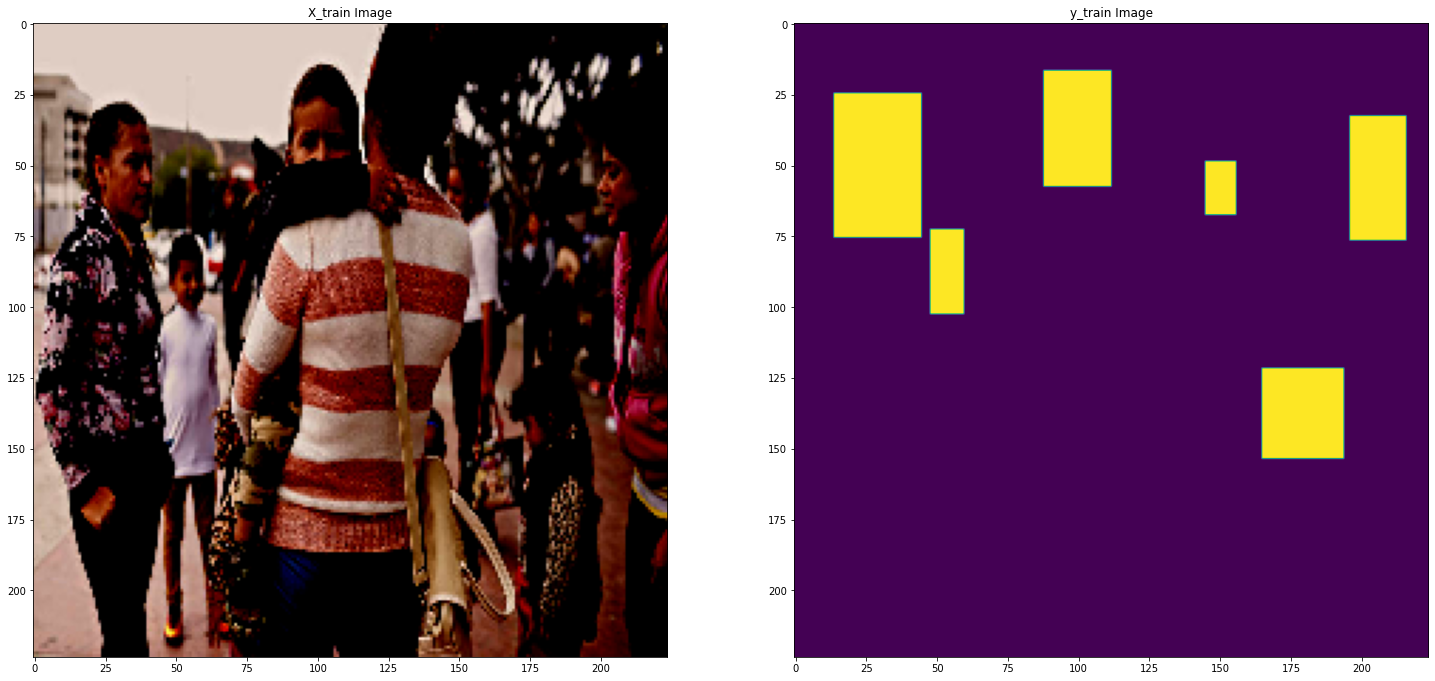

In [9]:
#Displaying 23rd image of train data
ax = []
fig = plt.figure(figsize=(25, 25))
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(X_train[24])
ax[0].set_title('X_train Image')
ax.append(fig.add_subplot(1, 2, 2))
ax[1].set_title('y_train Image')
plt.imshow(y_train[24])
plt.show()

In [10]:
#Displaying 3rd row of test data
print('Test Image Sample Array: \n{}'.format(X_test[3]))
print('\nTest Image Sample Mask: \n',y_test[3])

Test Image Sample Array: 
[[[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.06666672  0.17647064]
  [ 0.07450986  0.23137259  0.33333337]]

 [[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.05882359  0.17647064]
  [ 0.07450986  0.22352946  0.33333337]]

 [[ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  [ 0.97647059  0.97647059  0.92941177]
  ...
  [-0.1607843  -0.01176471  0.10588241]
  [-0.09019607  0.05882359  0.17647064]
  [ 0.07450986  0.22352946  0.33333337]]

 ...

 [[ 0.68627453  0.53725493  0.4666667 ]
  [ 0.60000002  0.47450984  0.37254906]
  [ 0.72549021  0.58431375  0.48235297]
  ...
  [ 0.33333337  0.32549024  0.29411769]
  [ 0.3176471   0.29411769  0.3176471 ]
  [ 0.37254906  0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


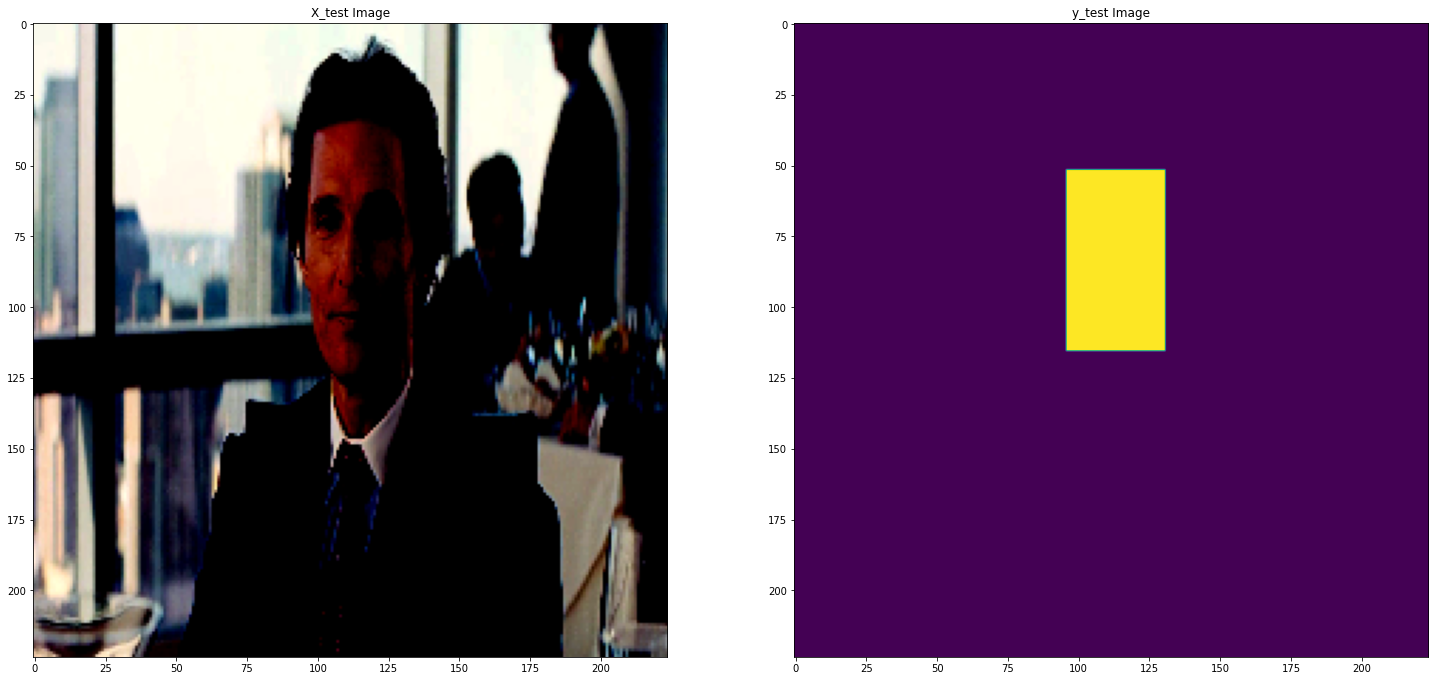

In [11]:
#Displaying 3rd image of train data
ax = []
fig = plt.figure(figsize=(25, 25))
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(X_test[3])
ax[0].set_title('X_test Image')
ax.append(fig.add_subplot(1, 2, 2))
ax[1].set_title('y_test Image')
plt.imshow(y_test[3])
plt.show()

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [85]:
from tensorflow.keras.applications.mobilenet import MobileNet#Importing the Mobilenet model
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D#Importing the Layers for building the model
from tensorflow.keras.models import Model#Importing the model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=1.0, weights="imagenet")#Calling the mobilenet model

    for layer in model.layers:
        layer.trainable = trainable
        #Calling the Layers to build Unet
    block0 = model.get_layer("conv_pw_1_relu").output 
    block = model.get_layer("conv_pw_1_relu").output
    block1 = model.get_layer("conv_pw_3_relu").output
    block2 = model.get_layer("conv_pw_5_relu").output
    block3 = model.get_layer("conv_pw_11_relu").output
    block4 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block4), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = Concatenate()([UpSampling2D()(x), block])
    x = UpSampling2D()(x)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)

    x = Reshape((IMAGE_HEIGHT, IMAGE_HEIGHT))(x)

    return Model(inputs=model.input, outputs=x)
    

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [86]:
HEIGHT_CELLS = 28
WIDTH_CELLS = 28
model = create_model(False)#Creating Model by calling the function

### Print model summary (1 mark)

In [87]:
#Summay of the model
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


In [88]:
#Creating the dice_coefficient function
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function (2 marks)

In [89]:
#Creating the loss function
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [90]:
from tensorflow.keras.optimizers import Adam #Importing Adam Optimizer
from tensorflow.keras.losses import binary_crossentropy #Importing Binary Crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #Calling the Optimizer Function
#Compile the model with Adam as optimizer , Dice_Coefficient as Metrics and binary_crossentropy as loss function
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [104]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True, save_weights_only=True)
#Defining the Early stopping with patience 3
stop = EarlyStopping(monitor="loss", patience=3)

reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [107]:
#Calling the fit for train data
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6070 - dice_coefficient: 0.6953
Epoch 2/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6054 - dice_coefficient: 0.6958
Epoch 3/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6074 - dice_coefficient: 0.6954
Epoch 4/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6068 - dice_coefficient: 0.6954
Epoch 5/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6068 - dice_coefficient: 0.6954
Epoch 6/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6065 - dice_coefficient: 0.6959
Epoch 7/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6060 - dice_coefficient: 0.6958
Epoch 8/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6084 - dice_coefficient: 0.6948
Epoch 9/100
309/309 [==============================] - 6s 18ms/step - loss: 0.6072 - dice_coefficient: 0.6950
Epoch 10/1

### Get the predicted mask for a test image   (2 marks)

Show the test image

Show original mask for test image

In [109]:
#Display the test Image and its mask array
print('Test Image Sample Array: \n{}'.format(X_test[5]))
print('\nTest Image Sample Mask: \n',y_test[5])

Test Image Sample Array: 
[[[-0.83529413 -0.71764708 -0.86666667]
  [-0.81176472 -0.71764708 -0.82745099]
  [-0.81176472 -0.67843139 -0.82745099]
  ...
  [-0.96862745 -0.92156863 -0.92156863]
  [-0.96862745 -0.92156863 -0.92156863]
  [-0.96862745 -0.92156863 -0.92156863]]

 [[-0.84313726 -0.72549021 -0.87450981]
  [-0.80392158 -0.7019608  -0.83529413]
  [-0.81960785 -0.68627453 -0.83529413]
  ...
  [-0.96862745 -0.92156863 -0.92156863]
  [-0.96862745 -0.92156863 -0.92156863]
  [-0.96862745 -0.92156863 -0.92156863]]

 [[-0.84313726 -0.73333335 -0.86666667]
  [-0.80392158 -0.68627453 -0.83529413]
  [-0.80392158 -0.67058825 -0.81960785]
  ...
  [-0.96862745 -0.92156863 -0.92156863]
  [-0.96862745 -0.92156863 -0.92156863]
  [-0.96862745 -0.92156863 -0.92156863]]

 ...

 [[ 0.57647061  0.58431375  0.60000002]
  [ 0.56078434  0.59215689  0.60000002]
  [ 0.5529412   0.59215689  0.60000002]
  ...
  [ 0.49019611  0.54509807  0.58431375]
  [ 0.23921573  0.27058828  0.32549024]
  [-0.87450981 -0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


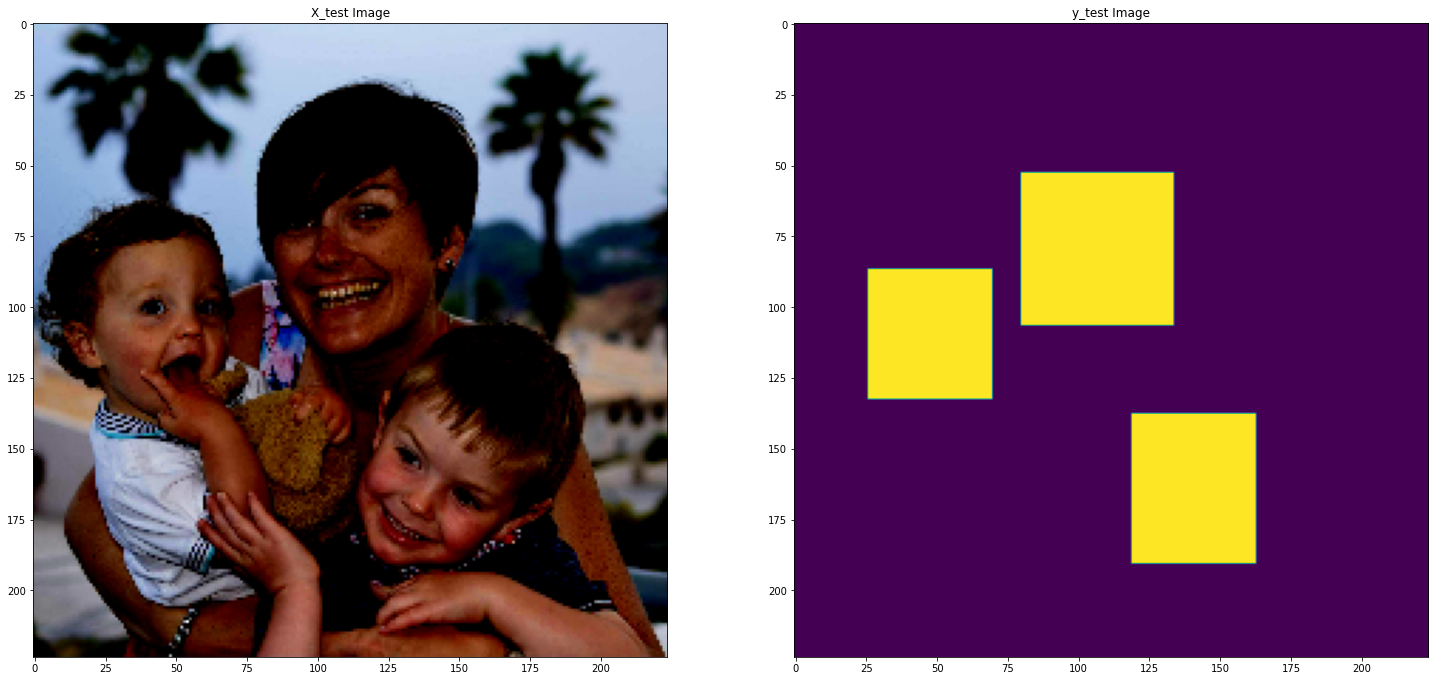

In [110]:
#Display the test Image and its mask image
ax = []
fig = plt.figure(figsize=(25, 25))
ax.append(fig.add_subplot(1, 2, 1))
plt.imshow(X_test[0])
ax[0].set_title('X_test Image')
ax.append(fig.add_subplot(1, 2, 2))
ax[1].set_title('y_test Image')
plt.imshow(y_test[0])
plt.show()

Predict the mask on the test image

In [111]:
#Predicting the model for the test
pred_mask = model.predict(X_test,verbose=1)

1/1 [==============================] - 0s 89ms/step


### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

In [112]:
#Get the threshold predictions to look at refined results.
pred_mask_t = (pred_mask > 0.5).astype(np.uint8)

In [115]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'), levels=[0.5])
    ax[0].set_title('Original Image')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Original Mask')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'), levels=[0.5])
    ax[2].set_title('Predicted Mask')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors=('r', 'green', 'blue', (1, 1, 0), '#afeeee', '0.5'), levels=[0.5])
    ax[3].set_title('Predicted Mask Binary');

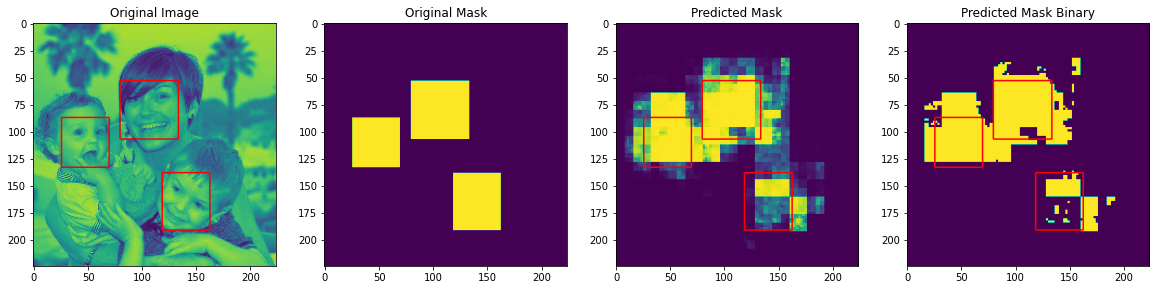

In [116]:
plot_sample(X_test, y_test, pred_mask, pred_mask_t, ix=0)

The model is providing the Binary_Entropy loss 0.6054 as and dice coefficient as 0.6964.
It is predicting the model properly.